In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import ndimage
from scipy.ndimage import zoom
import gc
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.backends.cudnn as cudnn
import types
from scipy.stats import pearsonr, spearmanr
import torchio as tio
from datetime import datetime
import wandb
###
from models.lds_utils import get_lds_kernel_window
from models.loss import *
from models.sfcn_fds import *
from collections import Counter
from scipy.ndimage import zoom, convolve1d

In [3]:
RANDOM_SEED = 551

In [4]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [5]:
def load_data(img_dir, label_dir, label_name, std=False, norm=False):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for i, index in enumerate(tqdm(filenames)):
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        if norm:
            img = (img - img.min()) / (img.max() - img.min())
        if std:
            m = np.mean(img)
            s = np.std(img)
            img = (img - m) / s
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [6]:
def image_preprocess(img_size=192):
    # [16,32,48,64,80,96,112,128,144,160]
    sample_rate = 300 / img_size
    # transformation
    transform = tio.Compose([
        tio.Resample(sample_rate),
        tio.ZNormalization(),
    ])
    return transform

In [7]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=12,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(20,20,20))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

In [8]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.X = X
        self.y = y.values
        self.transform = transform
        
        self.bin_edges = np.histogram_bin_edges(self.y, bins='auto')
        self.weights = self._prepare_weights(lds=lds, lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        if self.transform is not None:
            image = self.transform(image)
        label = np.array([self.y[idx]]).astype('float16')
        weight = np.array([self.weights[idx]]).astype('float16') if self.weights is not None else np.asarray([np.float16(1.)])
        return [image, label, weight]
    
    def _prepare_weights(self, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):  
        weights = None
        if lds:
            labels = self.y
            bin_index_per_label = [self._get_bin_idx(label) for label in labels]
            Nb = max(bin_index_per_label) + 1
            num_samples_of_bins = dict(Counter(bin_index_per_label))
            emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

            lds_kernel_window = get_lds_kernel_window(kernel=lds_kernel, ks=lds_ks, sigma=lds_sigma)
            eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

            eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
            weights = np.array([np.float32(1 / x) for x in eff_num_per_label]).reshape(labels.shape)
        return weights
    
    def _get_bin_idx(self, label):
        return np.max(np.where(self.bin_edges <= label))

In [9]:
def train(model, train_loader, epoch, optimizer, lds=False, fds=False):
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
        
    total_mae_loss, total_mse_loss = 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.train()
    for inputs, labels, weights in tqdm(train_loader):              
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        weights = weights.to(device, dtype=torch.float)
        optimizer.zero_grad()

        if fds:
            output, _ = model(inputs, labels, epoch)
        else:
            output = model(inputs, labels, epoch)
        
        pred = output.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
        if lds:
            mae_loss = criterion1(output, labels)
            mse_loss = weighted_mse_loss(output, labels, weights=weights)
        else:
            mae_loss = criterion1(output, labels)
            mse_loss = criterion2(output, labels)
#         mae_loss.backward()
        mse_loss.backward()
        
        optimizer.step()
        
        total_mae_loss += mae_loss.data.item()
        total_mse_loss += mse_loss.data.item()
        
        gc.collect()
        torch.cuda.empty_cache()
        
    if fds and epoch >= start_update:
        encodings, targets = [], []
        with torch.no_grad():
            for inputs, labels, _ in tqdm(train_loader):
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                outputs, feature = model(inputs, labels, epoch)
                encodings.extend(feature.data.squeeze().cpu().numpy())
                targets.extend(labels.data.squeeze().cpu().numpy())
                
        encodings, targets = torch.from_numpy(np.vstack(encodings)).cuda(), torch.from_numpy(np.hstack(targets)).cuda()
        if device_count > 1:
            model.module.FDS.update_last_epoch_stats(epoch)
            print('feature_dim:', model.module.FDS.feature_dim)
            print('features.size(1):', encodings.size(1))
            model.module.FDS.update_running_stats(encodings, targets, epoch)
        else:
            model.FDS.update_last_epoch_stats(epoch)
            model.FDS.update_running_stats(encodings, targets, epoch)
        
    return preds, truths, total_mae_loss, total_mse_loss

In [10]:
def valid(model, valid_loader):
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
    
    total_mae_loss, total_mse_loss = 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.eval()
    with torch.no_grad():
        for inputs, labels, _ in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            output = model(inputs)
            
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            mae_loss = criterion1(output, labels)
            mse_loss = criterion2(output, labels)
            
            total_mae_loss += mae_loss.data.item()
            total_mse_loss += mse_loss.data.item()
        
    return preds, truths, total_mae_loss, total_mse_loss

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
device_count = torch.cuda.device_count()
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [12]:
label_name = 'FL_WMH_VOL_icv'
# label_name = 'FL_WMH_VOL_mL'
# label_name = 'WMH_GRADE'
# label_name = 'Cortical Gray Matter Total Percent Of Icv'
# label_name = 'FL_PVWMH_VOL_icv'
# label_name = 'FL_DWMH_VOL_icv'
# img_dir = 'img_npy/'
img_dir = './input_numpy_300/' 
label_dir = 'labels/data_975.csv'

In [13]:
# 이번 실험 고정 값
lds = False
fds = True
batch_size = 4
test_batch_size = 4
epochs = 5
dropout_rate = 0.5
start_update = 0

In [14]:
# load data
X, y = load_data(img_dir, label_dir, label_name, std=False, norm=False)

# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# train set
# train_set = NeckDataset(X_train, y_train)

100%|█████████████████████████████████████████| 975/975 [02:24<00:00,  6.75it/s]


In [15]:
# image preprocessing
preprocess = image_preprocess()

# test set & loader
test_set = NeckDataset(X_test, y_test, transform=preprocess)
test_loader = DataLoader(test_set, batch_size=test_batch_size, num_workers=16)

len(X_train), len(X_test), len(y_train), len(y_test)

(780, 195, 780, 195)

(1, 192, 192, 192)
[1.478]
[0.03845]


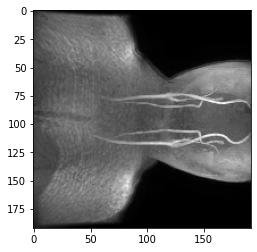

In [16]:
## 데이터셋 확인 (with LDS)
train_set = NeckDataset(X_train, y_train, transform=preprocess, lds=True)

for img, label, weight in train_set:
    print(img.shape)
    print(label)
    print(weight)
    plt.imshow(np.max(img, axis=2).squeeze(), cmap='gray')
    plt.show()
    break

In [17]:
# bins = np.linspace(0, 5, 30)

# plt.hist(y_train, bins, label='training set')
# plt.hist(y_test, bins, label='test set')
# plt.legend(loc='upper right')
# plt.show()
# plt.close()


# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.hist(y_train, bins, label='training set')
# plt.legend(loc='upper right')

# plt.subplot(1,2,2)
# plt.hist(y_test, bins, label='test set')
# plt.legend(loc='upper right')

# plt.show()
# plt.close()

---

In [18]:
# 바꿀 값
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

In [22]:
model = SFCN_FDS(dropout_p=dropout_rate, fds=fds, avg_shape=[5, 5, 5])
# model.fc.linear_0.in_features = 384
# model.FDS.feature_dim = 384
model.fc.add_module('relu', nn.LeakyReLU())
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model

DataParallel(
  (module): SFCN_FDS(
    (feature_extractor): Sequential(
      (conv_0): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_1): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_2): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation

In [19]:
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds, avg_shape=[5, 5, 5])
# model.fc.linear_0.in_features = 384
# model.FDS.feature_dim = 384
model.fc.add_module('relu', nn.LeakyReLU())
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

# wandb.init(
#     project='2023-warmup',
#     config={"model": "SFCN",
#             "start_lr": lr, "epochs": epochs, "batch_size": batch_size,
#             "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
#             "lds": lds, "fds": fds},
#     notes='train with %d data'%(len(train_set)))
# wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    transform = tio.transforms.Compose([preprocess, augment])
    train_set = NeckDataset(X_train, y_train, transform=transform, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
#         torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
#         torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

#     wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
#                "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
# wandb.finish()
# torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


# Epoch 1 / 5


100%|█████████████████████████████████████████| 195/195 [01:34<00:00,  2.07it/s]


asdf
feataure_dim: 64
features.size(1): 64


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


# Epoch 2 / 5


100%|█████████████████████████████████████████| 195/195 [01:36<00:00,  2.02it/s]


asdf
feataure_dim: 64
features.size(1): 64


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.92it/s]


# Epoch 3 / 5


100%|█████████████████████████████████████████| 195/195 [01:33<00:00,  2.08it/s]


asdf
feataure_dim: 64
features.size(1): 64


100%|███████████████████████████████████████████| 49/49 [00:26<00:00,  1.84it/s]


# Epoch 4 / 5


100%|█████████████████████████████████████████| 195/195 [01:30<00:00,  2.15it/s]


asdf
feataure_dim: 64
features.size(1): 64


100%|███████████████████████████████████████████| 49/49 [00:26<00:00,  1.87it/s]


# Epoch 5 / 5


100%|█████████████████████████████████████████| 195/195 [01:30<00:00,  2.16it/s]


asdf
feataure_dim: 64
features.size(1): 64


100%|███████████████████████████████████████████| 49/49 [00:26<00:00,  1.88it/s]


In [23]:
# 바꿀 값
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

In [19]:
from models.vnet_encoder_reg import Regressor

In [20]:
blocknum = 1
normalization = 'groupnorm'
img_size = 192
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]

model = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
# model.fc.linear_out.in_features = num_fc[0]
# model.FDS.feature_dim = num_fc[0]
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
model

DataParallel(
  (module): Regressor(
    (encoder): Sequential(
      (block_1): ResidualConvBlock(
        (conv): Sequential(
          (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm3D()
          (2): ReLU(inplace=True)
        )
      )
      (block_1_dw): DownsamplingConvBlock(
        (conv): Sequential(
          (0): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
          (1): GroupNorm3D()
          (2): ReLU(inplace=True)
        )
      )
    )
    (decoder): Sequential(
      (block_2): ResidualConvBlock(
        (conv): Sequential(
          (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm3D()
          (2): ReLU(inplace=True)
        )
      )
      (block_2_up): UpsamplingDeconvBlock(
        (conv): Sequential(
          (0): ConvTranspose3d(32, 16, kernel_size=(2, 2, 2), stride=(2, 2, 2))
          (1): GroupNorm3D()
          (2): ReLU(inplace=Tru

In [22]:
blocknum = 1
avg_pool = 5
normalization = 'groupnorm'
img_size = 192

set_seed()

out_size = 2 ** blocknum
out_size = 192 // out_size
out_size = out_size // 5
num_fc = [out_size * out_size * out_size,30,16,4]
model = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], avg_shape=avg_pool, dropout_p=dropout_rate, fds=fds)
# model.fc.linear_out.in_features = num_fc[0]
# model.FDS.feature_dim = num_fc[0]
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
model.cuda()

# wandb.init(
#     project='2023-warmup',
#     config={"model": "SFCN",
#             "start_lr": lr, "epochs": epochs, "batch_size": batch_size,
#             "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
#             "lds": lds, "fds": fds},
#     notes='train with %d data'%(len(train_set)))
# wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    transform = tio.transforms.Compose([preprocess, augment])
    train_set = NeckDataset(X_train, y_train, transform=transform, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
#         torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
#         torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

#     wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
#                "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
# wandb.finish()
# torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


# Epoch 1 / 5


100%|█████████████████████████████████████████| 195/195 [01:31<00:00,  2.14it/s]


feature_dim: 32768
features.size(1): 32768


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s]
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Epoch 2 / 5


100%|█████████████████████████████████████████| 195/195 [01:29<00:00,  2.18it/s]


feature_dim: 32768
features.size(1): 32768


100%|███████████████████████████████████████████| 49/49 [00:26<00:00,  1.82it/s]


# Epoch 3 / 5


100%|█████████████████████████████████████████| 195/195 [01:30<00:00,  2.14it/s]


feature_dim: 32768
features.size(1): 32768


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.78it/s]


# Epoch 4 / 5


100%|█████████████████████████████████████████| 195/195 [01:31<00:00,  2.13it/s]


feature_dim: 32768
features.size(1): 32768


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.81it/s]


# Epoch 5 / 5


100%|█████████████████████████████████████████| 195/195 [01:29<00:00,  2.17it/s]


feature_dim: 32768
features.size(1): 32768


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.81it/s]


---

In [ ]:
# 바꿀 값
weight_decay = 0.01
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

In [ ]:
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc.add_module('relu', nn.LeakyReLU())
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


---

In [ ]:
# 바꿀 값
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

In [ ]:
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc.add_module('relu', nn.LeakyReLU())
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


---

In [ ]:
# 바꿀 값
weight_decay = 0.1
lr = 1e-04
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

In [ ]:
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc.add_module('relu', nn.LeakyReLU())
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


---

In [ ]:
# 바꿀 값
weight_decay = 0.1
lr = 1e-05
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

In [ ]:
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc.add_module('relu', nn.LeakyReLU())
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


---

In [ ]:
# 바꿀 값
weight_decay = 0.1
lr = 1e-03
optim_class = optim.Adam
sched_class = optim.lr_scheduler.ReduceLROnPlateau

In [ ]:
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc.add_module('relu', nn.LeakyReLU())
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse+Adam_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse+Adam_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse+Adam_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


---

In [ ]:
# 바꿀 값
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.CosineAnnealingWarmRestarts

In [ ]:
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc.add_module('relu', nn.LeakyReLU())
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, T_0=10)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step()
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


---

In [ ]:
# 바꿀 값
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.CosineAnnealingLR

In [ ]:
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc.add_module('relu', nn.LeakyReLU())
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, T_max=50)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step()
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


---

In [15]:
# 바꿀 값
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

In [ ]:
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc.add_module('relu', nn.LeakyReLU())
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfds+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.98it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.10it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.94it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 9 / 150


 61%|██████████████████████████▎                | 30/49 [00:18<00:09,  1.97it/s]

---

In [15]:
weight_decay = 0.1
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau

In [16]:
# FC layer +1
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc = nn.Sequential(
    nn.Linear(64,16),
    nn.ReLU(),
    nn.Linear(16,1),
    nn.LeakyReLU(),
)
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr, "fc_added": 1})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc1+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc1+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfdsfc1+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.04it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.96it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.02it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.09it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.94it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.14it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.23it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.23it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.20it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.95it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.30it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.22it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.08it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.93it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.11it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.05it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.16it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.06it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.11it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.06it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.09it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.07it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.10it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.15it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.33it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.30it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.19it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.96it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


lr,███████▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▇▇▆▅▄▄▂▁▃▂▁▂▂▂▃▁▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▁▂
train_mse,█▇▇▅▅▄▄▃▂▂▁▁▂▂▂▃▂▂▁▂▂▃▁▂▂▂▁▂▂▂▂▂▂▂▁▂▂▂▁▁
train_pearson,▁▂▃▄▅▅▆▇▇▇██▇█▇▇███▇█▇█▇█▇█▇▇▇█▇▇▇█▇▇▇██
train_spearman,▁▃▄▆▅▆▇▇▇▇▇█▇█▇▇█▇███▇▇▇█▇▇█▇███▇█▇█▇▇██
valid_mae,▇█▄█▃▁▆█▆▅▅▅▅▆▅▆▅▅▅▅▅▅▅▅▅▅▅▄▅▄▅▄▅▅▅▅▆▅▄▅
valid_mse,█▇▅▃▂▁▁▄▃▂▁▁▁▂▂▂▁▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁
valid_pearson,▁▃▅▆▇▇█▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇███▇██▇▇▇█▇▇█▇
valid_spearman,▁▃▅▄▅▅█▆▇▇███████████▇███▇████▇██████▇██
lr,0.0
train_mae,0.29089


In [17]:
# FC layer +2
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc = nn.Sequential(
    nn.Linear(64,16),
    nn.ReLU(),
    nn.Linear(16,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.LeakyReLU(),
)
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr, "fc_added": 2})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc2+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc2+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfdsfc2+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.94it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.05it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.13it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.18it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.11it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.10it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.04it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.12it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.03it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.13it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.03it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.22it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.96it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.15it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.03it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.11it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.13it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.06it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.17it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.08it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.05it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.06it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.14it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.08it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.16it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.11it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.13it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.04it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.96it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


lr,███████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▆▆▅▅▄▄▃▂▂▁▁▂▂▃▃▂▂▂▂▂▂▂▂▁▂▂▃▁▁▂▂▂▂▁▂▂▂▂▂
train_mse,█▇▆▆▅▄▄▃▂▃▁▂▃▂▃▃▂▂▂▃▂▂▂▃▂▃▂▃▂▂▂▂▂▂▁▂▂▃▂▂
train_pearson,▁▃▃▄▅▆▆▇▇▇█▇▇▇▇▆▇▇▇▇▇▇▇▇█▇▇▆▇▇▇█▇▇█▇▇▇▇▇
train_spearman,▁▄▅▅▅▆▇██████▇▇▇▇▇▇█▇█▇▇▇▇▇▇████████▇▇▇▇
valid_mae,▄▃▂█▁▂▄▄▄▄▃▃▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▃▄▃▄▃▄▃▄▄▃▄
valid_mse,█▆▁▅▁▂▅▄▃▁▂▂▁▃▂▂▂▂▂▂▂▃▂▂▃▂▂▂▂▁▂▁▂▁▂▁▂▂▁▂
valid_pearson,▂▁▄▄█▆▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
valid_spearman,▂▁▆▄▄▅▆█████████████████████████████████
lr,0.0
train_mae,0.28624


In [18]:
# FC layer +3
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc = nn.Sequential(
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,16),
    nn.ReLU(),
    nn.Linear(16,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.LeakyReLU(),
)
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr, "fc_added": 3.1})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc3.1+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc3.1+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfdsfc3.1+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.08it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.94it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.95it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.10it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.03it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.04it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.98it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.39it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.24it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.39it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.24it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.14it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.12it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.95it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.25it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


lr,█████████▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,██▇▆▆▅▄▄▃▃▃▁▂▂▂▂▂▂▂▂▁▃▁▃▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▂
train_mse,██▇▆▅▅▄▄▃▄▂▂▂▂▂▃▂▂▂▂▁▃▂▃▂▂▂▂▂▂▂▂▃▂▁▂▂▂▂▂
train_pearson,▁▃▄▅▅▆▆▆▇▆▇█▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇▇▇██▇▇█▇██▇█
train_spearman,▁▅▆▆▇▇▇▇█▇███████▇███████▇██████████████
valid_mae,▇▅▅▆▅▂█▃▄▁▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▃▄▄▄▄▃▄▄▃▄
valid_mse,█▇▅▃▂▅▄▂▃▁▃▃▃▃▂▃▃▃▂▃▃▃▃▃▃▃▃▃▂▃▂▃▃▃▃▂▃▃▂▃
valid_pearson,▁▄▅▆▇▅▇▇▆█▇▇▇▇█▇▇▇█▇█▇█▇▇▇▇██▇██▇▇▇█▇▇█▇
valid_spearman,▁▆▇▇▇▄█▆▇▇██████████████████████████████
lr,0.0
train_mae,0.26514


In [19]:
# FC layer +3
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.LeakyReLU(),
)
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr, "fc_added": 3.2})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc3.2+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc3.2+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfdsfc3.2+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.94it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.33it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.33it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.17it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.30it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.20it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.07it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


lr,█████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▆▆▅▅▃▃▂▃▃▂▂▂▂▂▂▂▂▂▃▂▂▁▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂
train_mse,█▇▆▅▅▃▃▂▂▃▂▂▂▂▂▂▁▂▂▃▁▂▁▁▁▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁
train_pearson,▁▃▄▅▅▆▇▇▇▇▇█▇▇▇▇█▇▇▇█▇████▇██▇██▇▇█▇████
train_spearman,▁▄▆▅▆▇██▇▇████▇▇▇▇▇▇█▇▇▇▇▇▇█████▇█▇▇▇▇█▇
valid_mae,██▆▃▃▁▃▄▃▃▂▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▃▂▂▂
valid_mse,█▆▄▁▂▁▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▁▄▆████▇████████████████████████████████
valid_spearman,▁▅▆▇█▇███▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
lr,0.0
train_mae,0.28515


In [20]:
# FC layer +4
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,4),
    nn.ReLU(),
    nn.Linear(4,2),
    nn.ReLU(),
    nn.Linear(2,1),
    nn.LeakyReLU(),
)
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr, "fc_added": 4.1})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc4.1+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc4.1+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfdsfc4.1+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.95it/s]
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 7 / 150


 43%|██████████████████▍                        | 21/49 [00:14<00:18,  1.48it/s]


KeyboardInterrupt: 

In [21]:
# FC layer +4
set_seed()

model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
model.fc = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,8),
    nn.ReLU(),
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.LeakyReLU(),
)
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230307-sfcn+lkrelu+fds',
           config={"model": "sfcn+lkrelu+fds", "dropout": dropout_rate,
                   "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                   "scheduler": sched_class.__name__, "lds": lds, "fds": fds,
                   "start_lr": lr, "fc_added": 4.2})
wandb.watch(model)

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, optimizer, lds=lds, fds=fds)
    preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if best_mse > valid_mse:
        best_mse = valid_mse
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc4.2+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
    if best_mae > valid_mae:
        best_mae = valid_mae
        torch.save(model.state_dict(), 'pretrained/230308_sfcnfdsfc4.2+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()
torch.save(model.state_dict(), 'pretrained/230307_sfcnfdsfc4.2+mse_{}_w{}_slr{}_epochs{}'.format(sched_class.__name__, weight_decay, lr, epochs))


lr,▁▁▁▁▁▁
train_mae,█▄▃▂▂▁
train_mse,█▃▃▂▁▁
train_pearson,█▁▃▄▅▂
train_spearman,▁▄▇▇█▅
valid_mae,█▆▅▃▂▁
valid_mse,█▆▄▃▂▁
lr,0.001
train_mae,0.41677
train_mse,0.32745
train_pearson,-0.02077


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.06it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.21it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.18it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.95it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.94it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.03it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.96it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.06it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.24it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.95it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.04it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.17it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.23it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.16it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.08it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.09it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.12it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.10it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.32it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.32it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.28it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.95it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.96it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


lr,███████▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▇▆▅▅▄▄▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▁▃▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▂
train_mse,█▇▆▅▅▄▄▃▂▂▁▁▂▁▁▃▂▂▁▂▁▃▁▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▂▁
train_pearson,▁▃▄▅▅▅▆▇▇▇██▇██▇▇▇█▇█▇█▇█▇▇▇█▇██▇▇█▇▇█▇█
train_spearman,▁▃▅▅▅▆▆▆▆█▇██▇▇▇▇▇████▇▇▇█▇▇▇▇█▇▇▇▇▇▇▇▇▇
valid_mae,█▇▄█▄▁▅▆▅▄▄▄▄▅▄▅▄▄▅▅▄▅▅▄▄▅▄▄▄▄▄▄▅▄▄▄▄▄▄▄
valid_mse,█▆▅▃▃▅▂▃▂▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▁▂▅▆▇█▇▆▇███████████████████████████████
valid_spearman,▂▃▃▅▆▁█▅▇█▇██▇████▇▇█▇███▇███▇▇███▇█▇▇██
lr,0.0
train_mae,0.28293


---

In [ ]:
import seaborn as sns

def predict(model, data_loader, title='', line=False):
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels, _ in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
    # Get correlation coefficients
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
    
    # For range setting
    _min = y_min
    _max = y_max
    
    # Figure size
#     plt.figure(figsize=(5, 5))
    
    # Reference line
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='gray', ls='--', label='Reference r = 1.0')
    
    # Regression Plot
    
    ## Scatter
    plt.scatter(truths, preds, c='steelblue', label='Pearson\'s r = {:.2f} / Spearman\'s r = {:.2f}'.format(pearson,spearman))
    
    ## Linear Regression Line
    if line:
        m, b = np.polyfit(truths, preds, 1)
        plt.plot(truths, m*truths + b, c='steelblue', label='m = {:.2f}'.format(m))
#     # Regression Plot at once
#     sns.regplot(x=truths, y=preds, ci=None, color='steelblue', label='Pearson r = {:.2f}'.format(pearson))

    if title != '':
        plt.title(title)
    
    plt.axis('square')
    plt.ylabel('Predicted WMH'); plt.xlabel('Ground Truth')
    plt.legend()
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.show()
    plt.close()
    
    return preds, truths

In [ ]:
y_min, y_max =y_test.min()-0.5, y_test.max()+0.5
y_min, y_max

In [ ]:
fds = True

# FDS net, best MSE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_bestmse'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# FDS net, best MAE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_bestmae'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# FDS net, epoch 150
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_epochs{}'.format(sched_class.__name__, fds, epochs)))
net.cuda()
_,_ = predict(net, test_loader)

In [ ]:
fds = False

# original net, best MSE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_bestmse'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, best MAE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_bestmae'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, epoch 150
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_epochs{}'.format(sched_class.__name__, fds, epochs)))
net.cuda()
_,_ = predict(net, test_loader)

In [ ]:
lds = True
fds = False

# original net, best MSE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_bestmse'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, best MAE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_bestmae'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, epoch 150
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_epochs{}'.format(sched_class.__name__, fds, epochs)))
net.cuda()
_,_ = predict(net, test_loader)

In [ ]:
lds = True
fds = True

# original net, best MSE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_bestmse'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, best MAE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_bestmae'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, epoch 150
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_epochs{}'.format(sched_class.__name__, fds, epochs)))
net.cuda()
_,_ = predict(net, test_loader)

In [ ]:
net = SFCN()
net.load_state_dict(torch.load('pretrained/230228_sfcn+mse_ReduceLROnPlateau_bestmse'))
# net.to(device)
# _,_ = predict(net, test_loader)

In [ ]:
dataset = NeckDataset(train_X, train_y)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16)
_,_ = predict(model, train_loader, 'Training set')